# Shap Explanation of Pipeline Object: Categorical Features

1. Numerical features: easily replace shap_value.data with the original data
2. Categorical features: OneHotEncoding, shap of the transformed data will be different from the original


In [134]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap

In [135]:
# create data set with numeric features first
n_features = 5
n_informative = 3
X, y = make_classification(n_samples=1000, n_features=n_features, n_informative = n_informative, shuffle=False, random_state = 42)
informative_features_names = [f'inform_{i+1}' for i in range(n_informative)]
random_features_names = [f'random_{i+n_informative+1}' for i in range(n_features - n_informative)]
X = pd.DataFrame(X, columns = informative_features_names + random_features_names)


In [136]:
# add categorical features, cat1 is a moderator, while cat2 is random
cat1 = np.random.choice(['x','y'], size = 1000)
X['inform_1'] = np.where(cat1=='x',X['inform_1'],-X['inform_1']) 
cat2 = np.random.choice(['a','b','c'], size = 1000)
X['cat1'] = cat1
X['cat2'] = cat2


In [137]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)
X_train.head()

,inform_1,inform_2,inform_3,random_4,random_5,cat1,cat2
720,1.843416,0.676333,-0.281051,-0.966531,0.825640,y,a
331,1.135741,0.256661,0.498601,0.558025,-0.739934,x,b
745,0.682212,-1.031067,-0.090467,-0.143642,1.300601,y,b
498,-0.345910,-0.335325,0.174666,0.243190,0.111911,y,c
419,0.698517,-2.028763,1.451289,0.961484,2.226475,x,a


# prepare processing pipeline

In [138]:
num_features = X.select_dtypes(include=np.number).columns
cat_features = X.select_dtypes(exclude=np.number).columns

In [139]:
num_transformer = Pipeline(steps = [
    ("scaler", StandardScaler()),
])

cat_transformer = Pipeline(steps = [
    ("encoder", OneHotEncoder()),
])

column_transformer = ColumnTransformer(transformers = [
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features),
])

model = xgb.XGBClassifier()

pipeline = Pipeline(steps = [
    ('preprocessing', column_transformer),
    ('model', model),
])

In [140]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['inform_1', 'inform_2', 'inform_3', 'random_4', 'random_5'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['cat1', 'cat2'], dtype='object'))])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callb...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

# Use shap to explain the pipeline object

In [141]:
explainer = shap.Explainer(pipeline['model'])
X_test_processed = pipeline['preprocessing'].transform(X_test)
shap_values = explainer(X_test_processed)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


It all went smoothly. But without meaningful feature names, the shap explaination won't help us much.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


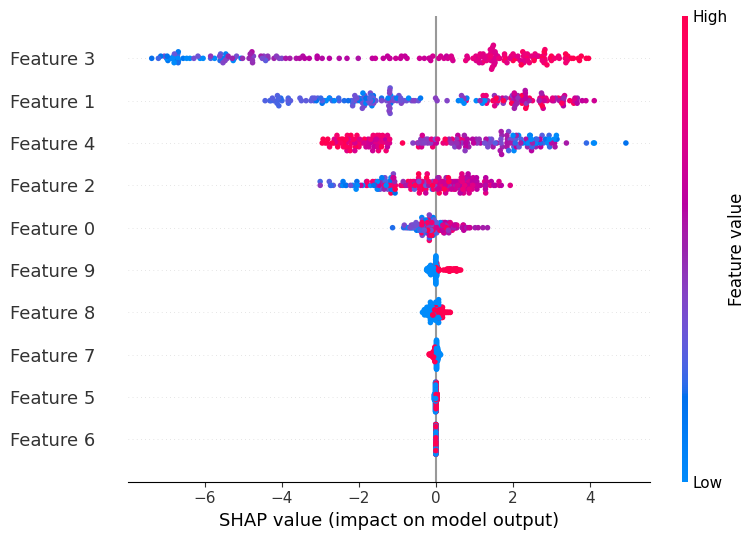

In [142]:
shap.summary_plot(shap_values)

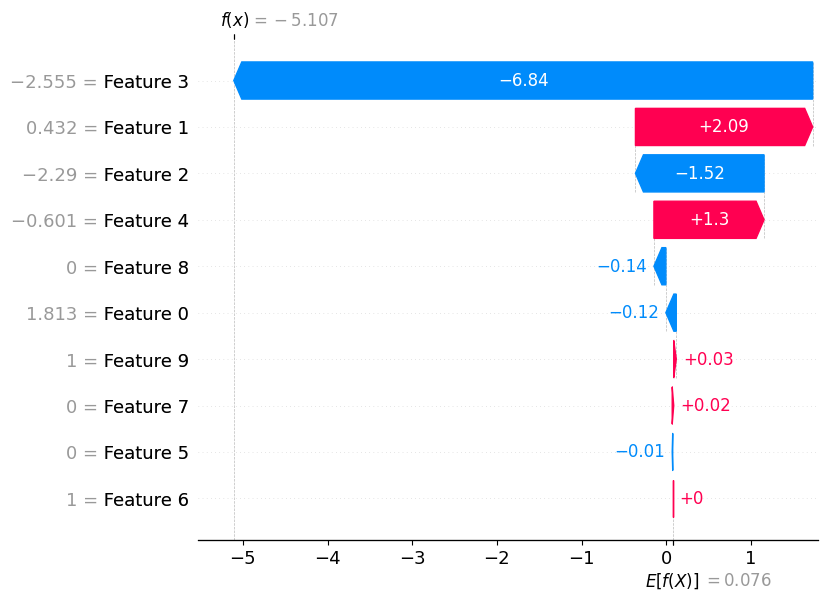

In [143]:
shap.plots.waterfall(shap_values[0])

# Create meaningful Shap_values.data 

1. Original values for num_features
2. HotEncoded column names for cat_features

In [144]:
transformed_cols = num_features.tolist()
encoder = pipeline['preprocessing'].named_transformers_['cat']['encoder']
for cat, values in zip(cat_features, encoder.categories_):
    transformed_cols += [f'{cat}_{value}' for value in values]

In [145]:
# get meaningful col names
X_test_processed_df = pd.DataFrame(X_test_processed, columns = transformed_cols)
# switch num features to original values
X_test_processed_df[num_features] = X_test[num_features]
shap_values.data = X_test_processed_df

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


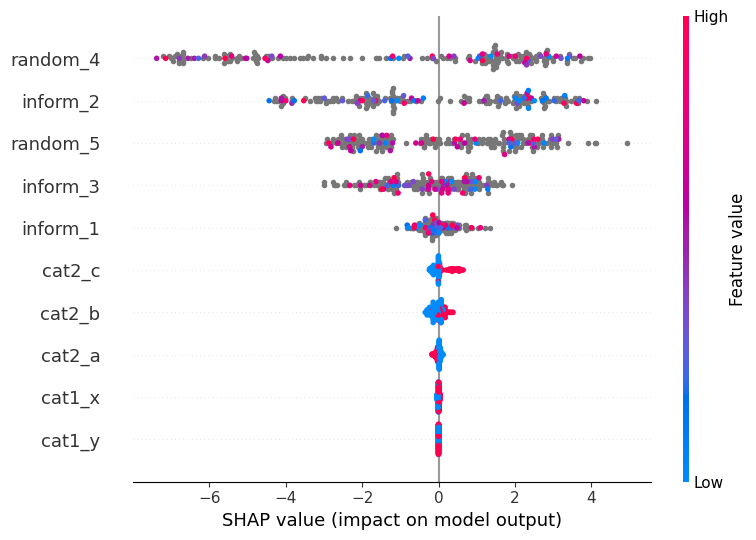

In [146]:
shap.summary_plot(shap_values)

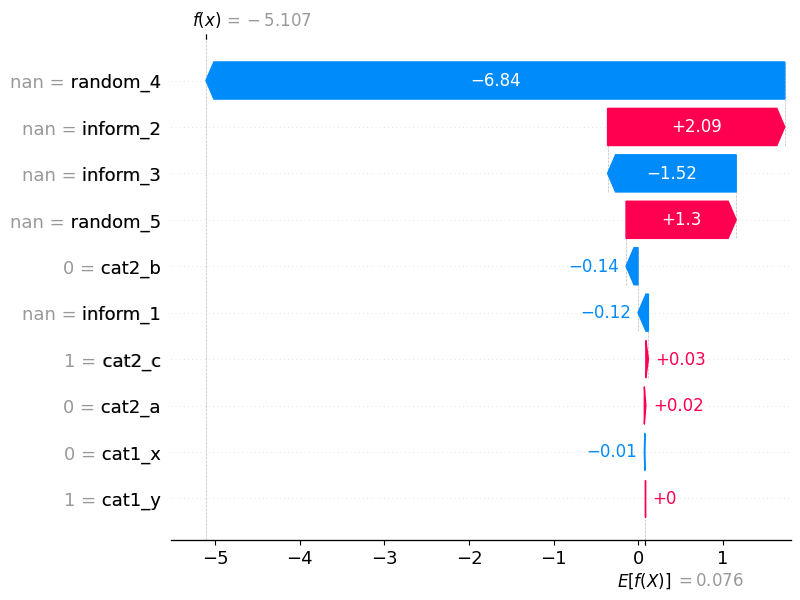

In [147]:
shap.plots.waterfall(shap_values[0])